# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Comparaison TfIdf / CamemBERT


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargement

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

## Labels ou textes Nuls

In [5]:
df_label['text'].isna().sum()

0

In [6]:
df_label['infox'].isna().sum()

4

In [7]:
df_label = df_label[df_label['infox'].notna()]

In [8]:
df_label.reset_index(inplace=True)

## Données dupliquées

In [9]:
df_label.duplicated(subset='text').sum()

0

In [10]:
df_label.duplicated(subset='url').sum()

0

# Experience
---

## Equilibrage Dataset

<Axes: xlabel='infox', ylabel='count'>

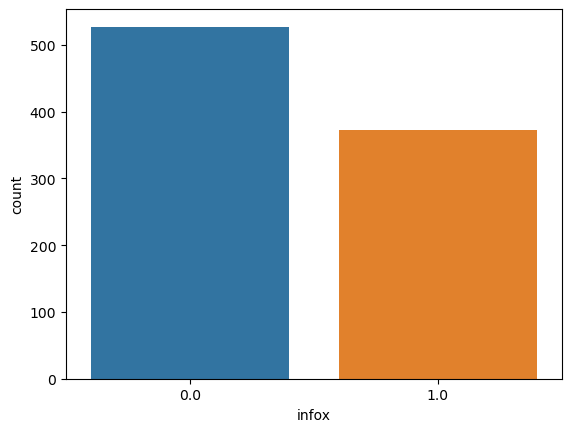

In [11]:
label_count = df_label['infox'].value_counts()
sns.barplot(x=label_count.index, y=label_count)

In [12]:
df_0 = df_label[df_label['infox'] == 0]
df_1 = df_label[df_label['infox'] == 1]

min_sample = min(len(df_0),len(df_1))


df_0=df_0.sample(min_sample,random_state=_rs)
df_1=df_1.sample(min_sample,random_state=_rs)
df_ml = pd.concat([df_0,df_1])[['text','infox']]

df_ml

,text,infox
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0
705,La vaccination Covid : un marquage de « type b...,0.0
26,Colonialisme énergétique\nVisite d’État du pré...,0.0
565,De l’importance d’une Assemblée vraiment natio...,0.0
231,Quelle politique migratoire pour la France ? –...,0.0
...,...,...
112,Des scientifiques de Harvard et de Johns Hopki...,1.0
157,L’armée russe achète des exemplaires d’armemen...,1.0
522,ONU – Le Premier ministre de Nouvelle-Zélande ...,1.0
847,Pandémie ou le retour du grand Pan\nAu cours d...,1.0


In [16]:
print(df_ml['text'][15])

Selon le Pr Perronne l’apparition de la variole du singe n’est pas naturelle
La variole du singe est une maladie extrêmement rare et limitée à l’Afrique. Soudain, on nous annonce que des cas ont été enregistrés aux États-Unis, au Canada, au Royaume-Uni, en Australie, en Suède, aux Pays-Bas, en Belgique, en France, en Espagne, en Italie et en Allemagne, tous en même temps. Son nom est monkeypox ou variole du singe, et c’est la panique !
ttention à celui qui risque de faire perdre des milliards. Les milliards que les laboratoires encaissent grâce à l’interdiction des traitements contre le covid-19 et à l’obligation vaccinale pour avoir le droit de travailler et de se déplacer. Il a tenu « des propos considérés comme indignes de la fonction qu’il exerce ». Qui est ce pelé, ce galeux ? Le Pr Perronne, bien sûr !
Depuis que ses critiques sur la pseudo épidémie de covid ont été confirmées. Avec la variole du singe, le scénario catastrophe recommence et Perronne, ce complotiste invétéré, reco

# Experience
---

## Expérience de cross validation pour mesurer la performance des modeles


`scores = cross_validate(classifier, X, y, cv=5, scoring = metriques)`

- `classifier` : Classifier
- `X` : Features
- `y` : Label cible
- `cv` : Nombre de cycle d'entrainement/test
- `scoring` : Métriques





In [18]:
cv=5
y = df_ml['infox']

## Tfidf 
Features : `X_tfidf`

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vectorizer = TfidfVectorizer()

In [21]:
X_tfidf = vectorizer.fit_transform(df_ml['text'])

## CamemBERT Embeddings 
Features : `X_embeddings`


In [24]:
import torch
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'device : {device}')

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('camembert-base')
model = AutoModel.from_pretrained('camembert-base').to(device)

device : mps


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
## function to generate BERT embeddings
def get_embeddings(text):
    input_ids = tokenizer.encode(text,add_special_tokens=True,return_tensors='pt').to(device)
    input_ids = input_ids[:,:512]
    with torch.inference_mode():
        last_hidden_state = model(input_ids)[0].to(device)
        embeddings = torch.mean(last_hidden_state,dim=1).squeeze().to(device)
        
    return embeddings.cpu().numpy()

In [26]:
%%time
import numpy as np
## Generate embeddings for the text data using BERT
X_embeddings = np.array([get_embeddings(text) for text in tqdm(df_ml['text'])])

  0%|          | 0/746 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 42.4 s, sys: 5.12 s, total: 47.5 s
Wall time: 47.7 s


In [27]:
X_embeddings[0]

array([ 4.19769250e-02,  4.23454158e-02, -3.18763889e-02,  9.86878276e-02,
        1.89667735e-02, -3.22453342e-02,  7.13314675e-03,  4.93381545e-02,
       -2.53091604e-02,  9.77859050e-02, -1.01855271e-01,  3.22715677e-02,
       -3.31885740e-02,  9.78013128e-02,  7.42584616e-02, -3.87406498e-02,
        8.93924683e-02, -2.00664327e-02,  2.13762075e-02,  1.99409761e-02,
        1.50038414e-02, -6.89888746e-02, -2.32275645e-03,  4.73537575e-03,
       -2.94595420e-01, -6.61907941e-02, -6.67871237e-02, -1.31989680e-02,
        2.82257050e-02, -3.03883050e-02,  8.74514878e-02,  5.94479516e-02,
        6.62120208e-02,  1.63540877e-02, -3.10775340e-02,  8.12281072e-02,
        5.12334257e-02, -1.68600753e-02,  1.07448548e-01, -8.83240402e-02,
       -1.15260351e-02, -3.47485319e-02,  6.40644925e-04,  2.10466720e-02,
       -7.69134164e-02,  8.88476670e-02,  2.84613632e-02,  4.05306518e-02,
        2.65690200e-02, -4.25820425e-02, -2.90742870e-02, -2.35107802e-02,
       -5.85930385e-02, -

## Comparaison sur SKLearn Logistic Regression

In [28]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [29]:
logreg = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)

### TfIdf

In [30]:
X = X_tfidf

In [31]:
scores = cross_validate(logreg, X, y, cv=cv,
                        scoring=('accuracy','f1','recall','roc_auc'))

In [32]:
df_scores=pd.DataFrame(scores)
df_means = pd.DataFrame(df_scores.describe().loc['mean'])

pd.set_option('display.precision',3)
df_results = df_means.T.drop(columns = ['fit_time','score_time'])
df_results.T

,mean
test_accuracy,0.782
test_f1,0.776
test_recall,0.756
test_roc_auc,0.853


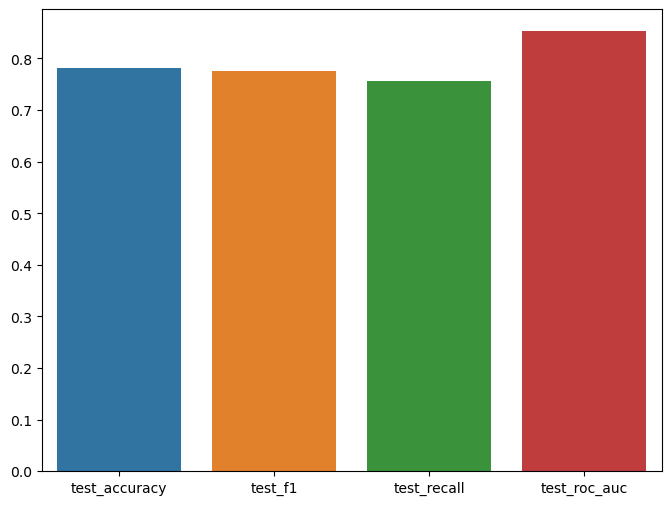

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.barplot(df_results)

### CamemBERT Embeddings

In [35]:
X = X_embeddings

In [36]:
scores = cross_validate(logreg, X, y, cv=cv,
                        scoring=('accuracy','f1','recall','roc_auc'))
df_scores=pd.DataFrame(scores)
df_means = pd.DataFrame(df_scores.describe().loc['mean'])

In [37]:
pd.set_option('display.precision',3)
df_results = df_means.T.drop(columns = ['fit_time','score_time'])
df_results.T

,mean
test_accuracy,0.751
test_f1,0.753
test_recall,0.766
test_roc_auc,0.834


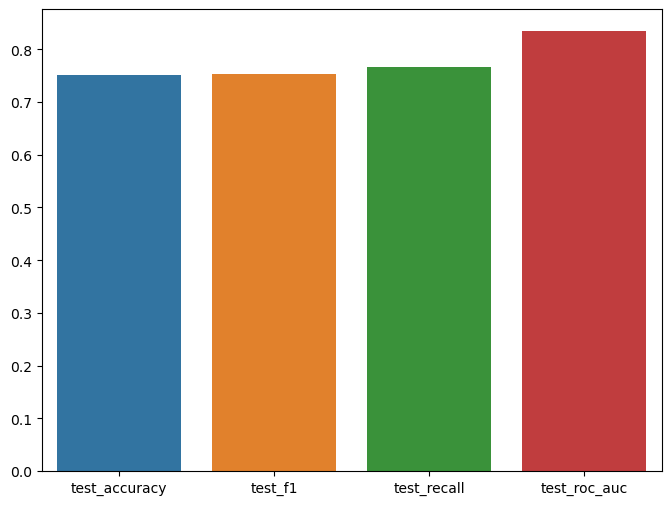

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.barplot(df_results)

# Conclusions
---





